# Custom batch model

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

In [2]:
bs = pd.read_csv("basic_sample.csv") #z=x*2+y*3+2
bs.sample(5)

,x,y,z
6,6,21,77
2,2,2,12
15,7,1,19
12,4,6,28
5,5,5,27


In [3]:
inputs = bs.drop('z', axis='columns')
inputs = inputs.values.reshape(bs.shape[0],2)
inputs

array([[ 1,  1],
       [ 2,  2],
       [ 2,  2],
       [ 3,  3],
       [ 4,  4],
       [ 5,  5],
       [ 6, 21],
       [ 7,  1],
       [ 1,  2],
       [ 1,  3],
       [ 2,  4],
       [ 3,  5],
       [ 4,  6],
       [ 5,  7],
       [ 6,  2],
       [ 7,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4]], dtype=int64)

In [4]:
inputs.shape

(19, 2)

In [5]:
z = bs['z'].values.reshape(bs.shape[0],1)
z

array([[ 7],
       [12],
       [12],
       [17],
       [22],
       [27],
       [77],
       [19],
       [10],
       [13],
       [18],
       [23],
       [28],
       [33],
       [20],
       [19],
       [10],
       [15],
       [20]], dtype=int64)

In [6]:
z.shape

(19, 1)

In [7]:
#model.evaluate(inputs, z)

class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
    def train(self, train_dataset, train_metric):
        for epoch in range(self.epochs):
            print("\nStart of epoch %d" % (epoch,))
            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    logits = model(x_batch_train, training=True)
                    loss_value = self.loss_fn(y_batch_train, logits)
                    # tf.print(loss_value)
                grads = tape.gradient(loss_value, model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
                # Update training metric.
                train_metric.update_state(y_batch_train, logits)
                # Log every 5 batches.
                if step % 5 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(loss_value))
                    )
                    print("Seen so far: %d samples" % ((step + 1) * self.batch))
                    print(train_metric.result().numpy())
                # Display metrics at the end of each epoch.
            train_acc = train_acc_metric.result()
            print("Training acc over epoch: %.4f" % (float(train_acc),))

In [8]:
inputs.shape

(19, 2)

In [9]:
inputs

array([[ 1,  1],
       [ 2,  2],
       [ 2,  2],
       [ 3,  3],
       [ 4,  4],
       [ 5,  5],
       [ 6, 21],
       [ 7,  1],
       [ 1,  2],
       [ 1,  3],
       [ 2,  4],
       [ 3,  5],
       [ 4,  6],
       [ 5,  7],
       [ 6,  2],
       [ 7,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4]], dtype=int64)

In [10]:
import time

class custom_train:
    
    
    def __init__(self, model, optimizer_fn, loss_fn, metric_fn):
        self.model = model
        self.optimizer = optimizer_fn
        self.loss_fn = loss_fn
        self.metrics = metric_fn

    #tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            #print(f'x:{x}, y:{y} {type(x)}')
            logits = self.model(x, training=True)
            loss_value = self.loss_fn(y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.metrics.update_state(y, logits)
        return loss_value

    def train(self, inputs, outputs, epochs, batch_size, batch_log, loss_threshold):
        loss_list = []
        epoch_list = []
        start_time = time.time()
        for epoch in range(epochs):
            loss_value = self.train_step(inputs, outputs)
            
            # Display metrics at the end of each epoch.
            train_acc = self.metrics.result()
            
            if epoch%50==0:
                loss_list.append(loss_value)
                epoch_list.append(epoch)
                print(
                    "Training acc over epoch: %.4f Training loss (for one batch) at step %d: %.4f Time taken: %.2fs " 
                    % (float(train_acc), epoch, float(loss_value), (time.time() - start_time))
                )
            if loss_value <= loss_threshold:
                break
            # Reset training metrics at the end of each epoch
            self.metrics.reset_states()
            
        return loss_list, epoch_list

In [11]:
input_layer = keras.Input(shape=(2,))
hidden_layer = keras.layers.Dense(2)(input_layer)
output_layer = keras.layers.Dense(1)(hidden_layer)

model = keras.Model(input_layer, output_layer)
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
my_train = custom_train(model, optimizer, loss_function, metric)
loss_list, epoch_list = my_train.train(inputs, z, 5000, 15, 5, 0.01)


Training acc over epoch: 26.8371 Training loss (for one batch) at step 0: 1109.6434 Time taken: 0.40s 
Training acc over epoch: 25.4958 Training loss (for one batch) at step 50: 1006.7225 Time taken: 0.96s 
Training acc over epoch: 24.2469 Training loss (for one batch) at step 100: 915.8417 Time taken: 1.51s 
Training acc over epoch: 22.9993 Training loss (for one batch) at step 150: 829.8531 Time taken: 2.03s 
Training acc over epoch: 21.7277 Training loss (for one batch) at step 200: 746.7721 Time taken: 2.56s 
Training acc over epoch: 20.4350 Training loss (for one batch) at step 250: 666.9426 Time taken: 3.07s 
Training acc over epoch: 19.1249 Training loss (for one batch) at step 300: 590.7771 Time taken: 3.57s 
Training acc over epoch: 17.8011 Training loss (for one batch) at step 350: 518.6499 Time taken: 4.11s 
Training acc over epoch: 16.4682 Training loss (for one batch) at step 400: 450.9133 Time taken: 4.68s 
Training acc over epoch: 15.1314 Training loss (for one batch) at

Training acc over epoch: 0.1649 Training loss (for one batch) at step 4000: 0.0387 Time taken: 43.89s 
Training acc over epoch: 0.1611 Training loss (for one batch) at step 4050: 0.0361 Time taken: 44.56s 
Training acc over epoch: 0.1572 Training loss (for one batch) at step 4100: 0.0338 Time taken: 45.15s 
Training acc over epoch: 0.1533 Training loss (for one batch) at step 4150: 0.0316 Time taken: 45.75s 
Training acc over epoch: 0.1493 Training loss (for one batch) at step 4200: 0.0296 Time taken: 46.30s 
Training acc over epoch: 0.1454 Training loss (for one batch) at step 4250: 0.0278 Time taken: 46.86s 
Training acc over epoch: 0.1414 Training loss (for one batch) at step 4300: 0.0261 Time taken: 47.42s 
Training acc over epoch: 0.1374 Training loss (for one batch) at step 4350: 0.0245 Time taken: 48.00s 
Training acc over epoch: 0.1334 Training loss (for one batch) at step 4400: 0.0229 Time taken: 48.57s 
Training acc over epoch: 0.1294 Training loss (for one batch) at step 445

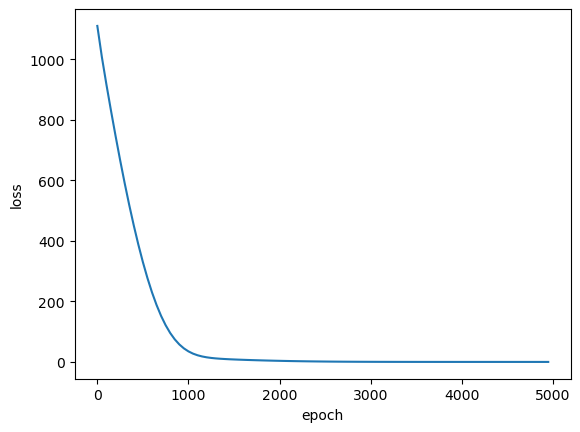

In [12]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(epoch_list, loss_list)


In [14]:
temp = np.array([[3, 2]], dtype='int64')

In [15]:
model.predict(temp)

1/1 [==============================] - 0s 63ms/step


array([[14.065841]], dtype=float32)